We will walkthrough a more complex form of time-series forecasting, which is LSTM. In this notebook, I build the LSTM model for predicting the FPT's stock price

Our goal in this project is to make the model smarter, as the Linear Regression one just use the data from the previous day to predict the next. We need to get rid of that first.

# 1. Import Libraries

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


# 2. Getting the Data / Preprocess


We use the build-in library which is the `vnstock` API from SSI

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from vnstock import Quote


symbol = 'MBB'
start_date = '2023-01-01'
end_date = '2026-01-14'


quote = Quote(symbol=symbol, source='VCI')

df = quote.history(start=start_date, end=end_date, interval='1D')

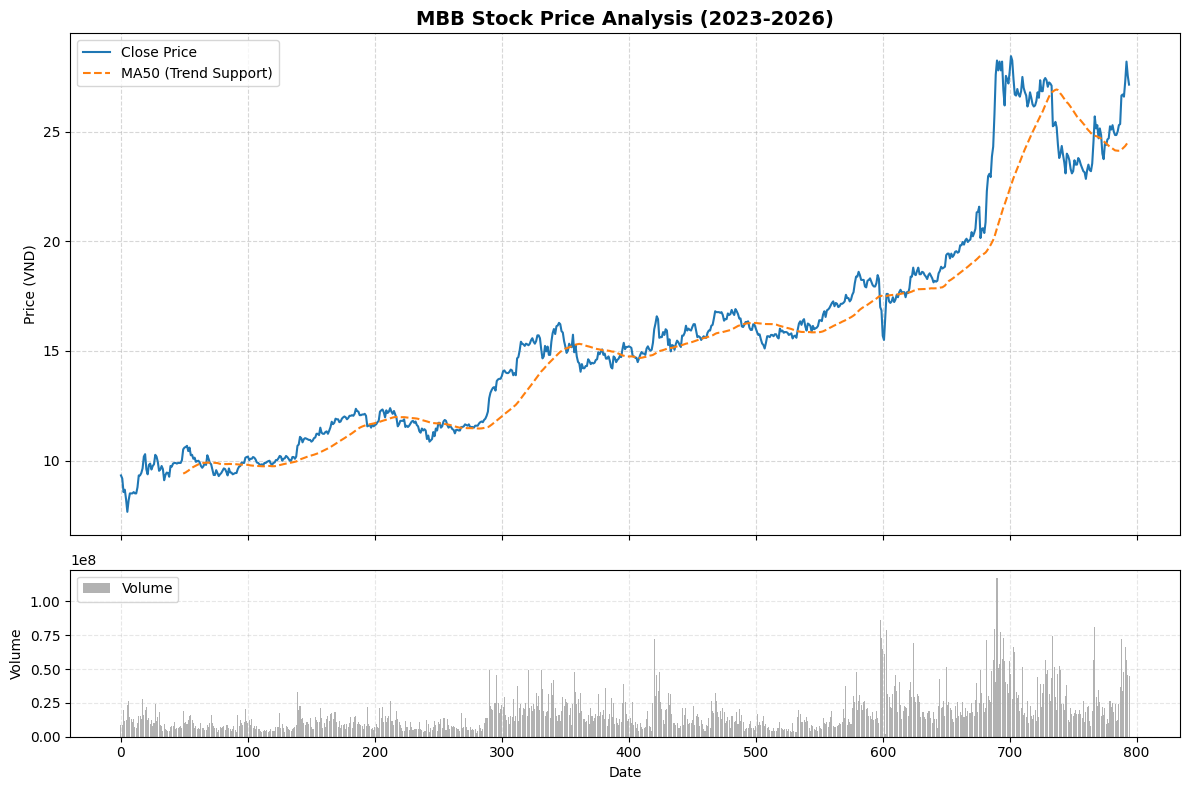

In [5]:
df['MA50'] = df['close'].rolling(window=50).mean()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# --- Top Chart: Price & MA ---
ax1.set_title('MBB Stock Price Analysis (2023-2026)', fontsize=14, fontweight='bold')
ax1.plot(df.index, df['close'], label='Close Price', color='#1f77b4', linewidth=1.5)
ax1.plot(df.index, df['MA50'], label='MA50 (Trend Support)', color='#ff7f0e', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Price (VND)')
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# --- Bottom Chart: Volume ---
ax2.bar(df.index, df['volume'], label='Volume', color='gray', alpha=0.6)
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, which='both', linestyle='--', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In order to put our data in the model, we need to preprocess it

Just to remind, this is the thing that we need to predict, the close price:

<Axes: >

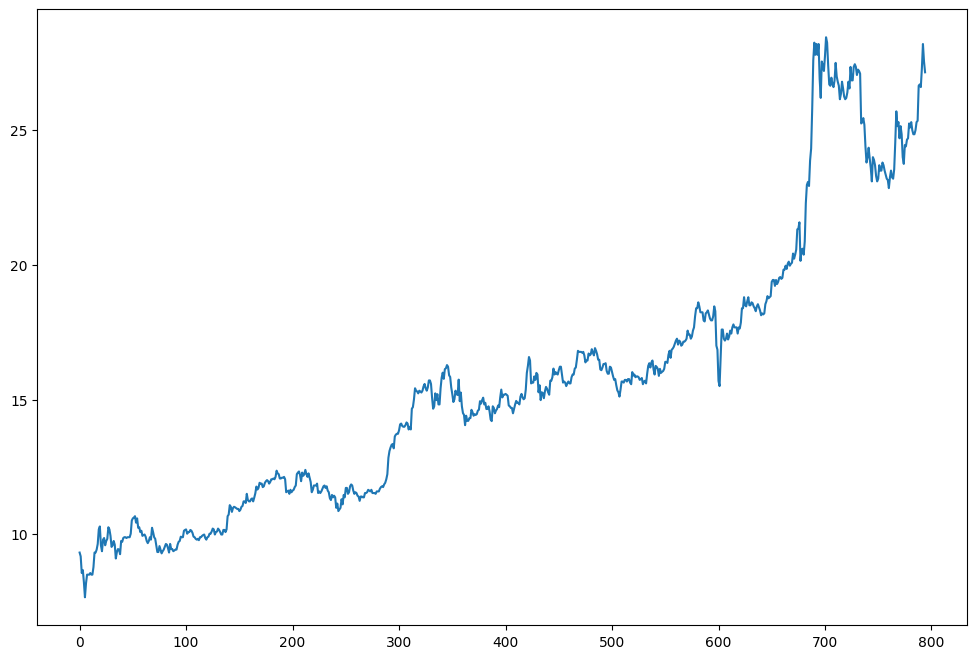

In [7]:
df.close.plot(figsize=(12,8))

In [ ]:
# Scale the data using StandardScaler
scaler = StandardScaler()

df['close'] = scaler.fit_transform(pd.DataFrame(df['close']))


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.